In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import random

In [2]:
trainset = torchvision.datasets.MNIST('/train_MNIST', train=True, download=True)
testset = torchvision.datasets.MNIST('/test_MNIST', train=False, download=True)

Extracting /train_MNIST/MNIST/raw/train-images-idx3-ubyte.gz to /train_MNIST/MNIST/raw


Extracting /train_MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to /train_MNIST/MNIST/raw



Extracting /train_MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to /train_MNIST/MNIST/raw


Extracting /train_MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to /train_MNIST/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting /test_MNIST/MNIST/raw/train-images-idx3-ubyte.gz to /test_MNIST/MNIST/raw




Extracting /test_MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to /test_MNIST/MNIST/raw


Extracting /test_MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to /test_MNIST/MNIST/raw


Extracting /test_MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to /test_MNIST/MNIST/raw
Processing...
Done!


In [3]:
train_X = []
train_Y = []
for datapoint in trainset:
  img = np.asarray(datapoint[0])
  train_X.append(img)
  train_Y.append(datapoint[1])

test_X = []
test_Y = []
for datapoint in testset:
  img = np.asarray(datapoint[0])
  test_X.append(img)
  test_Y.append(datapoint[1])

In [4]:
train_X = np.expand_dims(train_X, 1)
test_X = np.expand_dims(test_X, 1)

train_X = (train_X-0)/(255-0)
test_X = (test_X-0)/(255-0)

train_x = torch.tensor(train_X)
val_x = torch.tensor(test_X)

train_y = torch.LongTensor(train_Y)
val_y = torch.LongTensor(test_Y)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
class ClassifyNet(torch.nn.Module):
    def __init__(self):
        super(ClassifyNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1,2,3,1)
        self.conv2 = torch.nn.Conv2d(2,4,3,1)
        self.conv_bn_2 = torch.nn.BatchNorm2d(4)
        self.conv3 = torch.nn.Conv2d(4,8,3,1)
        self.conv4 = torch.nn.Conv2d(8,16,3,1)
        self.conv_bn_4 = torch.nn.BatchNorm2d(16)
        self.conv5 = torch.nn.Conv2d(16,32,3,1)
        self.conv6 = torch.nn.Conv2d(32,64,3,1)
        self.conv_bn_6 = torch.nn.BatchNorm2d(64)
        self.fc1 = torch.nn.Linear(256, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self,x):
        x=self.conv1(x)
        x=torch.nn.functional.relu(x)
        x=self.conv2(x)
        x=torch.nn.functional.relu(x)
        x=torch.nn.functional.max_pool2d(x,kernel_size = [2,2],stride=[2,2])
        x = self.conv_bn_2(x)
        x=self.conv3(x)
        x=torch.nn.functional.relu(x)
        x=self.conv4(x)
        x=torch.nn.functional.relu(x)
        # x=torch.nn.functional.max_pool2d(x,kernel_size = [2,2],stride=[2,2])
        x = self.conv_bn_4(x)
        x=self.conv5(x)
        x=torch.nn.functional.relu(x)
        x=self.conv6(x)
        x=torch.nn.functional.relu(x)
        x=torch.nn.functional.max_pool2d(x,kernel_size = [2,2],stride=[2,2])
        x = self.conv_bn_6(x)
        x = torch.flatten(x, 1)
        # print("Size",x.shape)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        x = torch.nn.functional.relu(x)
        x = self.fc3(x)
        # output = F.log_softmax(x, dim=1)
        return x

In [16]:
model = ClassifyNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',verbose=True,patience=200)
if torch.cuda.is_available():
    model = model.cuda()
    loss = loss.cuda()
    train_y = train_y.cuda()
    train_x = train_x.cuda()
    val_y = val_y.cuda()
    val_x = val_x.cuda()
print(model)

ClassifyNet(
  (conv1): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1))
  (conv_bn_2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv_bn_4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_bn_6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [17]:
def get_accuracy(pred,y):
    accu_sum=0
    for i in range(len(y)):
        maxi=-100000
        maxind=-1
        for j in range(10):
          # print(pred[i][j])
          if pred[i][j] >= maxi:
              maxind = j
              maxi=pred[i][j]
        if(maxind==y[i]):
            accu_sum+=1
        
    return accu_sum

In [18]:
index_list = np.arange(len(train_x))
val_index_list = np.arange(len(val_x))

train_losses= []
val_losses = []

train_accs = []
val_accs = []

batch_size = 64
cnt=-1
for epochs in range(20):
  random.shuffle(index_list)
  for batch_no in range(int(len(train_x)/batch_size)):
    cnt+=1
    # print(index_list[batch_size*batch_no:batch_size*(batch_no+1)])
    train_batch_x = train_x[index_list[batch_size*batch_no:batch_size*(batch_no+1)]] 
    train_batch_y = train_y[index_list[batch_size*batch_no:batch_size*(batch_no+1)]]

    output_train = model(train_batch_x.float())
    loss_train = loss(output_train, train_batch_y)
    train_losses.append(loss_train.item())
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if(cnt%1==0):
      random.shuffle(val_index_list)
      val_batch_x = val_x[val_index_list[:500]]
      val_batch_y = val_y[val_index_list[:500]]

      output_val = model(val_batch_x.float())
      loss_val = loss(output_val, val_batch_y)
      val_losses.append(loss_val.item())
      scheduler.step(loss_val.item())
    else:
      val_losses.append(val_losses[-1])

    if(cnt%10==0):
      val_accs.append(get_accuracy(output_val.cpu().detach().numpy(),val_batch_y.cpu().detach().numpy())/500)
      train_accs.append(get_accuracy(output_train.cpu().detach().numpy(),train_batch_y.cpu().detach().numpy())/batch_size)

  for param_group in optimizer.param_groups:
        lr = param_group['lr']

  if(lr<0.0000001):
    break

  print("Epoch #",epochs,"Completed")
  print(train_losses[-1],val_losses[-1])
  print(train_accs[-1],val_accs[-1])
  # if(epochs>=5):
  #   inp = input()
  #   if(inp == "s"):
  #     break

Epoch # 0 Completed
0.18804578483104706 0.03485875204205513
0.953125 0.978
Epoch  1163: reducing learning rate of group 0 to 1.0000e-04.
Epoch  1617: reducing learning rate of group 0 to 1.0000e-05.
Epoch  1818: reducing learning rate of group 0 to 1.0000e-06.
Epoch # 1 Completed
0.06111123040318489 0.02890319935977459
1.0 0.99
Epoch  2111: reducing learning rate of group 0 to 1.0000e-07.
Epoch  2519: reducing learning rate of group 0 to 1.0000e-08.


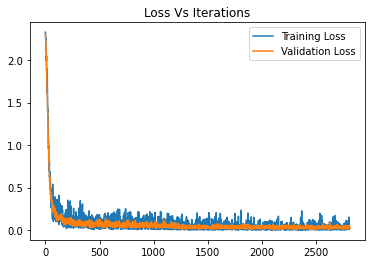

In [19]:
plt.plot(train_losses,label="Training Loss")
plt.plot(val_losses,label="Validation Loss")
plt.title("Loss Vs Iterations")
plt.legend()

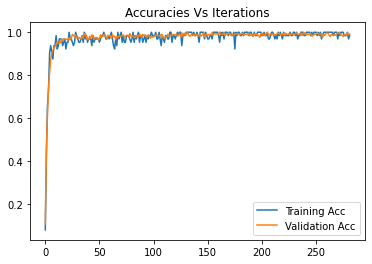

In [20]:
plt.plot(train_accs,label="Training Acc")
plt.plot(val_accs,label="Validation Acc")
plt.title("Accuracies Vs Iterations")
plt.legend()

In [21]:
# Accuracies

In [22]:
batch_size = 500
correct_preds=0
for batch_no in range(int(len(train_x)/batch_size)):
    train_batch_x = train_x[batch_size*batch_no:batch_size*(batch_no+1)] 
    train_batch_y = train_y[batch_size*batch_no:batch_size*(batch_no+1)]
    output_train = model(train_batch_x.float())
    correct_preds+=get_accuracy(output_train.cpu().detach().numpy(),train_batch_y.cpu().detach().numpy())
print("Overall Train Accuracy: ",100*correct_preds/len(train_x))

Overall Train Accuracy:  99.22833333333334


In [23]:
batch_size = 500
correct_preds=0
for batch_no in range(int(len(val_x)/batch_size)):
    val_batch_x = val_x[batch_size*batch_no:batch_size*(batch_no+1)] 
    val_batch_y = val_y[batch_size*batch_no:batch_size*(batch_no+1)]
    output_val = model(val_batch_x.float())
    correct_preds+=get_accuracy(output_val.cpu().detach().numpy(),val_batch_y.cpu().detach().numpy())
print("Overall Validation Accuracy: ",100*correct_preds/len(val_x))

Overall Validation Accuracy:  99.01


In [ ]:
# !unzip akshit_sum.zip

In [24]:
torch.save(model,"ClassifyNet")
from google.colab import files
files.download('ClassifyNet') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
data1 = np.load('akshit_sum/data0.npy')
data2 = np.load('akshit_sum/data1.npy')
data3 = np.load('akshit_sum/data2.npy')
lab1 = np.load('akshit_sum/lab0.npy')
lab2 = np.load('akshit_sum/lab1.npy')
lab3 = np.load('akshit_sum/lab2.npy')

In [ ]:
X = np.concatenate((data1,data2,data3))
Y = np.concatenate((lab1,lab2,lab3))
X = (X-0)/(255-0)

In [ ]:
def detect_number(img):
  stride_height = 3
  stride_width = 3
  max_is = []
  max_vals = []
  top_4 = []
  for j in np.arange(0,len(img[0])-28+1,stride_width):
    max_val=-1000
    max_i=-1000
    for i in np.arange(0,len(img)-28+1,stride_height):
      # plt.imshow(img[i:i+28,j:j+28])
      # plt.show()
      temp = img[i:i+28,j:j+28]

      temp = np.expand_dims(temp, 0)      # if numpy array
      temp = np.expand_dims(temp, 0)      # if numpy array
      # print(temp.shape)
      if torch.cuda.is_available():
        prob = (model(torch.tensor(temp).cuda().float()))
      else:
        prob = (model(torch.tensor(temp).float()))

      if(prob>max_val):
        max_val = prob.item()
        max_i = i
    
    max_is.append(max_i)
    max_vals.append(max_val)
#############
  max_i = -1000
  max_val = -1000
  for i in range(len(max_is)):
    if(max_vals[i]>max_val):
      max_i = i
      max_val = max_vals[i]

  top_4.append([max_is[max_i],np.arange(0,len(img[0])-28+1,stride_width)[max_i]])
  max_vals[max_i] = -10000

  if(max_i>0):
    max_vals[max_i-1] = -10000

  if(max_i<len(max_is)-1):
    max_vals[max_i+1] = -10000
#############
#############
  max_i = -1000
  max_val = -1000
  for i in range(len(max_is)):
    if(max_vals[i]>max_val):
      max_i = i
      max_val = max_vals[i]

  top_4.append([max_is[max_i],np.arange(0,len(img[0])-28+1,stride_width)[max_i]])
  max_vals[max_i] = -10000

  if(max_i>0):
    max_vals[max_i-1] = -10000

  if(max_i<len(max_is)-1):
    max_vals[max_i+1] = -10000
#############
#############
  max_i = -1000
  max_val = -1000
  for i in range(len(max_is)):
    if(max_vals[i]>max_val):
      max_i = i
      max_val = max_vals[i]

  top_4.append([max_is[max_i],np.arange(0,len(img[0])-28+1,stride_width)[max_i]])
  max_vals[max_i] = -10000

  if(max_i>0):
    max_vals[max_i-1] = -10000

  if(max_i<len(max_is)-1):
    max_vals[max_i+1] = -10000
#############
#############
  max_i = -1000
  max_val = -1000
  for i in range(len(max_is)):
    if(max_vals[i]>max_val):
      max_i = i
      max_val = max_vals[i]

  top_4.append([max_is[max_i],np.arange(0,len(img[0])-28+1,stride_width)[max_i]])
  max_vals[max_i] = -10000

  if(max_i>0):
    max_vals[max_i-1] = -10000

  if(max_i<len(max_is)-1):
    max_vals[max_i+1] = -10000
#############


  print(top_4)
  for i in top_4:
    plt.imshow(img[i[0]:i[0]+28,i[1]:i[1]+28])
    plt.show()